<a href="https://colab.research.google.com/github/GabrielG1997/COLAB/blob/main/RNA_ManuscritNumberIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plot
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [42]:
transform = transforms.ToTensor() # definindo a conversão de imagem para tensor (melhor formato de imagem para trabalhar com ML pois ).

trainset = datasets.MNIST('./MNIST_data/',download=True,train=True,transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

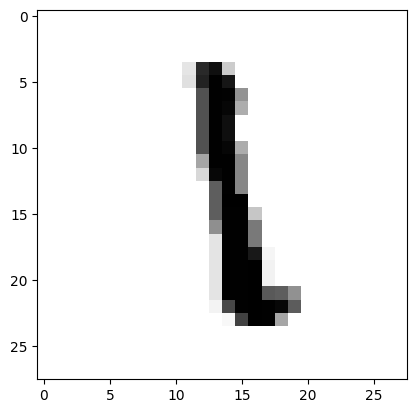

In [43]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plot.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [44]:
print(imagens[0].shape) # Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [45]:
class Modelo(nn.Module): # KERAS - InceptionV3 model
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neuronios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # camada interna I1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
    # para a camada de saida nao e necessario definir nada pois so precisamos pegar o output da camada interna 2

  def forward(self,X):
    X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
    return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [46]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos e da bias
  inicio = time() # timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
  EPOCHS = 100 # numero de epochs (épocas) que o algoritmo rodara
  modelo.train() # ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para ficarem compativeis com a entrada de uma rede neural totalmente conectada (fully connected).
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() # atualizando os pesos e a bias

      perda_acumulada += perda_instantanea.item() # atualização da perda acumulada


  else:
    print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("nTempo de treino (em minutos) =",(time()-inicio)/60)


In [47]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logaritmica

                ps = torch. exp(logps) # converte output para escala normal(lembrando que e um tensor)
                probab = list(ps.cpu().numpy() [0])
                etiqueta_pred = probab. index(max(probab)) # converte o tensor em um número, no caso, o numero que o modelo previu como correto
                etiqueta_certa = etiquetas.numpy() [i]
            if(etiqueta_certa == etiqueta_pred): # compara a previsao com o valor correto
                conta_corretas += 1
            conta_todas += 1

            print("Total de imagens testadas =", conta_todas)
            print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [48]:
modelo = Modelo() #Inicia o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo detectara se tiver gpu disponível para utilizacao, se não usara cpu
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [49]:
# Training
treino(modelo, trainloader, device)

# Validation
validacao(modelo, valloader, device)

Streaming output truncated to the last 5000 lines.

Precisão do modelo = 97.76817854571634%
Total de imagens testadas = 8335

Precisão do modelo = 97.76844631073786%
Total de imagens testadas = 8336

Precisão do modelo = 97.76871401151631%
Total de imagens testadas = 8337

Precisão do modelo = 97.76898164807484%
Total de imagens testadas = 8338

Precisão do modelo = 97.76924922043655%
Total de imagens testadas = 8339

Precisão do modelo = 97.76951672862454%
Total de imagens testadas = 8340

Precisão do modelo = 97.76978417266187%
Total de imagens testadas = 8341

Precisão do modelo = 97.77005155257163%
Total de imagens testadas = 8342

Precisão do modelo = 97.77031886837689%
Total de imagens testadas = 8343

Precisão do modelo = 97.77058612010069%
Total de imagens testadas = 8344

Precisão do modelo = 97.77085330776606%
Total de imagens testadas = 8345

Precisão do modelo = 97.77112043139604%
Total de imagens testadas = 8346

Precisão do modelo = 97.77138749101366%
Total de imagens tes